## Features engineering

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# On normalise les données continues 
from sklearn.preprocessing import StandardScaler

continuous_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                      'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()

# On applique le scaler uniquement sur les colonnes continues
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

# On ajuste les labels pour qu'ils commencent à 0 pour XGBoost
y_train_adj = y_train - 1
y_test_adj = y_test - 1

## Ajout climatic_zone et geologic_zone

On va va extraire les informations du code ELU des soil types et les utiliser directement dans nos modèles en ajoutant les nouvelles colonnes (climatic_zone et geologic_zone) aux caractéristiques d’entrée de nos modèles.

Les modèles d’arbres que nous utilisons (Random Forest, XGBoost et LightGBM) se basent sur des seuils de division et sont relativement robustes aux valeurs numériques dans les catégories, car ils créent des divisions basées sur les valeurs sans nécessairement interpréter une relation d’ordre. Donc on peut laisser les valeurs des colonnes climatic_zone et geologic_zone telles quelles.

In [3]:
# Dictionnaire des types de sols avec leurs codes ELU
soil_type_to_elu = {
    1: "2702",  2: "2703",  3: "2704",  4: "2705",  5: "2706",  6: "2717",
    7: "3501",  8: "3502",  9: "4201", 10: "4703", 11: "4704", 12: "4744",
    13: "4758", 14: "5101", 15: "5151", 16: "6101", 17: "6102", 18: "6731",
    19: "7101", 20: "7102", 21: "7103", 22: "7201", 23: "7202", 24: "7700",
    25: "7701", 26: "7702", 27: "7709", 28: "7710", 29: "7745", 30: "7746",
    31: "7755", 32: "7756", 33: "7757", 34: "7790", 35: "8703", 36: "8707",
    37: "8708", 38: "8771", 39: "8772", 40: "8776"
}

# Fonction pour extraire les composantes du code ELU
def extract_elu_components(elu_code):
    climatic_zone = int(elu_code[0])  # Premier chiffre pour la zone climatique
    geologic_zone = int(elu_code[1])  # Deuxième chiffre pour la zone géologique
    return climatic_zone, geologic_zone

# Fonction pour ajouter les colonnes climatic_zone et geologic_zone
def add_climatic_geologic_zones(df, soil_type_to_elu):
    # Faire une copie explicite du DataFrame pour éviter les effets de référence
    df = df.copy()
    
    # Initialiser des listes pour stocker les valeurs des zones climatiques et géologiques
    climatic_zones = []
    geologic_zones = []

    # Parcourir chaque ligne pour identifier le type de sol
    for i, row in df.iterrows():
        # Filtrer les colonnes `Soil_TypeX` pour cette ligne
        soil_type_columns = [col for col in df.columns if 'Soil_Type' in col]
        soil_type_values = row[soil_type_columns]
        
        # Vérifier si une seule colonne `Soil_TypeX` a la valeur 1
        if soil_type_values.sum() == 1:
            # Identifier le type de sol en trouvant la colonne avec la valeur 1
            soil_type = int(soil_type_values.idxmax().split('Soil_Type')[1])
            
            # Récupérer le code ELU pour le type de sol
            elu_code = soil_type_to_elu.get(soil_type)
            
            # Vérification supplémentaire : s'assurer que le code ELU existe
            if elu_code:
                # Extraire la zone climatique et géologique à partir du code ELU
                climatic_zone, geologic_zone = extract_elu_components(elu_code)
            else:
                # Si le code ELU est manquant, utiliser -1
                climatic_zone, geologic_zone = -1, -1
        else:
            # Si aucune colonne ou plusieurs colonnes sont égales à 1, utiliser -1
            climatic_zone, geologic_zone = -1, -1

        # Ajouter les valeurs aux listes
        climatic_zones.append(climatic_zone)
        geologic_zones.append(geologic_zone)

    # Vérifier que les longueurs des listes correspondent au nombre de lignes dans df
    assert len(climatic_zones) == len(df), "Erreur : La longueur des listes ne correspond pas au nombre de lignes du DataFrame"

    # Ajouter les nouvelles colonnes au DataFrame en utilisant `assign`
    df = df.assign(
        climatic_zone=pd.Series(climatic_zones, index=df.index, dtype="float"),
        geologic_zone=pd.Series(geologic_zones, index=df.index, dtype="float")
    )
    
    return df








On va maintenant tester si ça change quelque chose dans la performance de nos modèles.

In [4]:
# Vérifier que chaque ligne est affectée à un seul type de sol
unique_soil_type_assignment = (X_train.filter(regex='^Soil_Type').sum(axis=1) == 1).all()

if unique_soil_type_assignment:
    print("Chaque ligne est bien affectée à un seul type de sol.")
else:
    print("Certaines lignes ont plusieurs types de sol ou aucun type de sol assigné.")


Chaque ligne est bien affectée à un seul type de sol.


In [5]:
# print(X_train.shape)

X_train_soil = add_climatic_geologic_zones(X_train, soil_type_to_elu)
# print(X_train_soil[['climatic_zone', 'geologic_zone']].head())

#print(X_train_soil.shape)
#print(X_train_soil.head())

# Vérifier le nombre de NaN dans les colonnes `climatic_zone` et `geologic_zone`
nan_counts = X_train_soil[['climatic_zone', 'geologic_zone']].isna().sum()
print("Nombre de NaN dans chaque colonne :")
print(nan_counts)

Nombre de NaN dans chaque colonne :
climatic_zone    0
geologic_zone    0
dtype: int64


In [10]:

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Définir les modèles de base avec les meilleurs hyperparamètres
random_forest = RandomForestClassifier(
    n_estimators=300,  
    max_depth=None,      
    random_state=42,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
)
xgboost = XGBClassifier(
    colsample_bytree=0.9284956459967804,
    gamma=0.04924511492281908,
    learning_rate=0.24122412239323296,
    max_depth=9,
    n_estimators=300,
    subsample=0.9833984902058166,
    objective='multi:softmax',
    num_class=7,
    random_state=42
)

lightgbm = LGBMClassifier(
    colsample_bytree=0.9488048655607615,
    learning_rate=0.09224159033088929,
    max_depth=15,
    n_estimators=300,
    num_leaves=100,
    subsample=0.5190158468602316,
    objective='multiclass',
    num_class=7,
    random_state=42,
    verbosity=-1
)

# Définir le méta-modèle (un modèle simple comme la régression logistique)
meta_model = LogisticRegression(max_iter=1000)

# Créer le StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', random_forest),
        ('xgb', xgboost),
        ('lgbm', lightgbm)
    ],
    final_estimator=meta_model,
    cv=10  # Utiliser une validation croisée pour le stacking
)

# Entraîner le modèle de stacking
stacking_model.fit(X_train_soil, y_train_adj)

# Prédire sur l'ensemble de test
X_test_soil = add_climatic_geologic_zones(X_test, soil_type_to_elu)
y_pred_stack = stacking_model.predict(X_test_soil)

# Évaluer les performances du modèle de stacking
accuracy_stack = accuracy_score(y_test_adj, y_pred_stack)
print("Précision du modèle de stacking :", accuracy_stack)
print("Rapport de classification du modèle de stacking :\n", classification_report(y_test_adj, y_pred_stack))

Précision du modèle de stacking : 0.890652557319224
Rapport de classification du modèle de stacking :
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       648
           1       0.80      0.76      0.78       648
           2       0.89      0.90      0.89       648
           3       0.96      0.97      0.97       648
           4       0.94      0.94      0.94       648
           5       0.89      0.92      0.91       648
           6       0.95      0.94      0.95       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



Observons où sont nos erreurs avec une matrice de confusion.

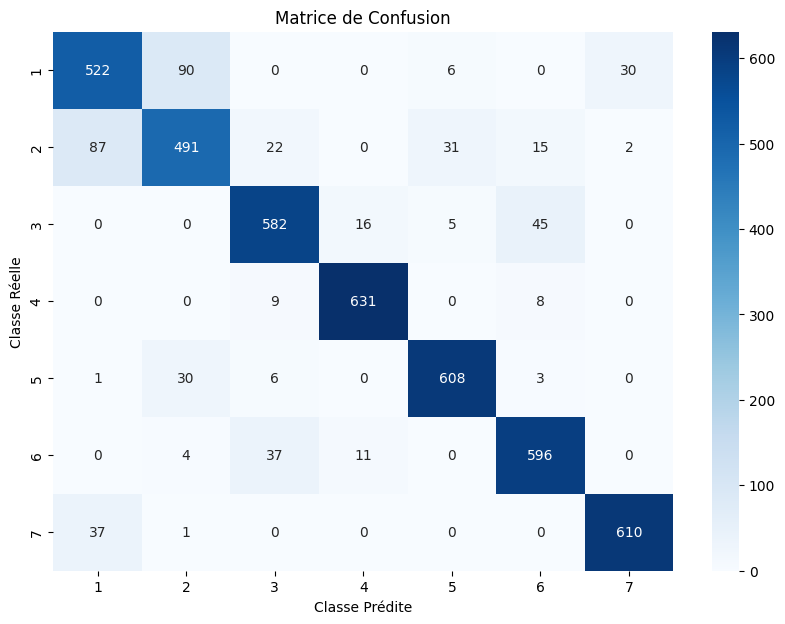

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_adj, y_pred_stack)

# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()

On va esssayer ce que ça donne sur le test complet.

In [12]:
y_adj = y - 1

X_test_full = pd.read_csv('test-full.csv')

In [13]:
X_soil = add_climatic_geologic_zones(X, soil_type_to_elu)

X_test_full_soil = add_climatic_geologic_zones(X_test_full, soil_type_to_elu)

In [14]:
# On entraîne le modèle de stacking
stacking_model.fit(X_soil, y_adj)

# On prédit sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_full_soil)

y_pred_stack = y_pred_stack + 1

In [15]:
# On crée un DataFrame avec les Id et les Cover_Type prédits
submission_df = pd.DataFrame({
    'Id': X_test_full['Id'],
    'Cover_Type': y_pred_stack
})

# On sauvegarde le DataFrame en fichier CSV
submission_df.to_csv('submission_soil10.csv', index=False)

résultat : $0,83419$

## Un seul attribut Soil_Type

On va essayer de ne plus avoir plusieurs attributs Soil_Type binaire mais d'en avoir un seul avec le numéro du Soil_Type. CEla pourrait bien marcher car les Soil_Types proches ont l'air d'avoir des numéros proches.

In [ ]:
# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# On normalise les données continues 
from sklearn.preprocessing import StandardScaler

continuous_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                      'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()

# On applique le scaler uniquement sur les colonnes continues
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

# On ajuste les labels pour qu'ils commencent à 0 pour XGBoost
y_train_adj = y_train - 1
y_test_adj = y_test - 1

In [ ]:
def consolidate_soil_type(df):
    # Filtrer les colonnes `Soil_TypeX`
    soil_type_columns = [col for col in df.columns if 'Soil_Type' in col]
    
    # Identifier l'index de la colonne `Soil_TypeX` ayant la valeur 1 pour chaque ligne
    # Cela donne le numéro du type de sol en supprimant "Soil_Type" du nom de la colonne
    df['Soil_Type'] = df[soil_type_columns].idxmax(axis=1).str.replace('Soil_Type', '').astype(int)
    
    # Supprimer les colonnes binaires `Soil_TypeX`
    df = df.drop(columns=soil_type_columns)
    
    return df

In [ ]:
X_train_consolidated = consolidate_soil_type(X_train)

In [ ]:
X_test_consolidated = consolidate_soil_type(X_test)

# Entraîner le modèle de stacking
stacking_model.fit(X_train_consolidated, y_train_adj)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=300,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9284956459967804,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamm...
                                              n_estimators=300, n_jobs=None,
                                              num_class=7,
                                              num_parallel_tree=None, ...)),
                               ('lgbm',
                                LGBMClassifier(colsample_bytree=0.9488048655607615,
                                               learning_rate=0.09224159033088929,
                                               max_depth=15, n_estimators=300,
                                               num_class=7, num_leaves=100,
                                               objective='multiclass',
                                               random_state=42,
                                               subsample=0.5190158468602316,
                                               verbosity=-1))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [ ]:
# Prédire sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_consolidated)

# Évaluer les performances du modèle de stacking
accuracy_stack = accuracy_score(y_test_adj, y_pred_stack)
print("Précision du modèle de stacking :", accuracy_stack)
print("Rapport de classification du modèle de stacking :\n", classification_report(y_test_adj, y_pred_stack))

Précision du modèle de stacking : 0.8913139329805997
Rapport de classification du modèle de stacking :
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       648
           1       0.81      0.77      0.79       648
           2       0.88      0.90      0.89       648
           3       0.96      0.97      0.97       648
           4       0.93      0.94      0.94       648
           5       0.90      0.91      0.91       648
           6       0.95      0.94      0.94       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



In [ ]:
X_test_full = pd.read_csv('test-full.csv')
X_consolidated = consolidate_soil_type(X)
X_test_full_consolidated = consolidate_soil_type(X_test_full)

In [ ]:
# On entraîne le modèle de stacking
stacking_model.fit(X_consolidated, y_adj)

# On prédit sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_full_consolidated)

y_pred_stack = y_pred_stack + 1

In [ ]:
# On crée un DataFrame avec les Id et les Cover_Type prédits
submission_df = pd.DataFrame({
    'Id': X_test_full['Id'],
    'Cover_Type': y_pred_stack
})

# On sauvegarde le DataFrame en fichier CSV
submission_df.to_csv('submission_consolidated.csv', index=False)

Résultat : $0,83333$

## Soil_type unique et climatic_zone et geologic_zone

In [ ]:
# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# On normalise les données continues 
from sklearn.preprocessing import StandardScaler

continuous_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                      'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()

# On applique le scaler uniquement sur les colonnes continues
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

# On ajuste les labels pour qu'ils commencent à 0 pour XGBoost
y_train_adj = y_train - 1
y_test_adj = y_test - 1

In [ ]:
def consolidate_soil_type_and_add_zones(df, soil_type_to_elu):
    # Étape 1 : Consolider les colonnes binaires `Soil_TypeX` en une seule colonne `Soil_Type`
    # Filtrer les colonnes `Soil_TypeX`
    soil_type_columns = [col for col in df.columns if 'Soil_Type' in col]
    
    # Identifier le type de sol pour chaque ligne
    soil_type_series = df[soil_type_columns].idxmax(axis=1).str.replace('Soil_Type', '').astype(int)
    df['Soil_Type'] = soil_type_series
    
    # Supprimer les colonnes binaires `Soil_TypeX`
    df = df.drop(columns=soil_type_columns)
    
    # Étape 2 : Ajouter les colonnes `climatic_zone` et `geologic_zone` en fonction de `Soil_Type`
    climatic_zones = []
    geologic_zones = []
    
    for soil_type in df['Soil_Type']:
        elu_code = soil_type_to_elu.get(soil_type)
        if elu_code:
            climatic_zone, geologic_zone = extract_elu_components(elu_code)
        else:
            climatic_zone, geologic_zone = -1, -1  # Valeurs par défaut si non trouvées
        climatic_zones.append(climatic_zone)
        geologic_zones.append(geologic_zone)
    
    # Ajouter les nouvelles colonnes au DataFrame
    df['climatic_zone'] = pd.Series(climatic_zones, index=df.index, dtype="int")
    df['geologic_zone'] = pd.Series(geologic_zones, index=df.index, dtype="int")
    
    return df


In [ ]:
X_train_consolidated_zones = consolidate_soil_type_and_add_zones(X_train, soil_type_to_elu)
X_test_consolidated_zones = consolidate_soil_type_and_add_zones(X_test, soil_type_to_elu)

In [ ]:
# Entraîner le modèle de stacking
stacking_model.fit(X_train_consolidated_zones, y_train_adj)

# Prédire sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_consolidated_zones)

# Évaluer les performances du modèle de stacking
accuracy_stack = accuracy_score(y_test_adj, y_pred_stack)
print("Précision du modèle de stacking :", accuracy_stack)
print("Rapport de classification du modèle de stacking :\n", classification_report(y_test_adj, y_pred_stack))

Précision du modèle de stacking : 0.8930776014109347
Rapport de classification du modèle de stacking :
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       648
           1       0.81      0.77      0.79       648
           2       0.89      0.90      0.90       648
           3       0.96      0.98      0.97       648
           4       0.93      0.95      0.94       648
           5       0.90      0.92      0.91       648
           6       0.95      0.94      0.94       648

    accuracy                           0.89      4536
   macro avg       0.89      0.89      0.89      4536
weighted avg       0.89      0.89      0.89      4536



In [ ]:
X_test_full = pd.read_csv('test-full.csv')
X_consolidated_zones = consolidate_soil_type_and_add_zones(X, soil_type_to_elu)
X_test_full_consolidated_zones = consolidate_soil_type_and_add_zones(X_test_full, soil_type_to_elu)

In [ ]:
# On entraîne le modèle de stacking
stacking_model.fit(X_consolidated_zones, y_adj)

# On prédit sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_full_consolidated_zones)

y_pred_stack = y_pred_stack + 1

In [ ]:
# On crée un DataFrame avec les Id et les Cover_Type prédits
submission_df = pd.DataFrame({
    'Id': X_test_full['Id'],
    'Cover_Type': y_pred_stack
})

# On sauvegarde le DataFrame en fichier CSV
submission_df.to_csv('submission_consolidated_zones.csv', index=False)

Résultat : $0,83277$